<a href="https://colab.research.google.com/github/cjflanagan/genie-1/blob/master/simple_clinical_trials_classifier_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from time import time
import pandas as pd
import seaborn as sns
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import auth
auth.authenticate_user()

# Clinical trials classifier using clinical trial features only

## Load data and assign labels

In [0]:
# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'harvard-599-trendsetters'

startTime = time()

df = pd.io.gbq.read_gbq(f'''
  SELECT
  a.nct_id,
  IF(enrollment IS NULL, -1, enrollment) AS enrollment,
  IF(number_of_arms IS NULL, -1, number_of_arms) AS number_of_arms,
  CASE
    WHEN NET.PUBLIC_SUFFIX(email) IS NULL THEN 'no_email'
    WHEN NET.PUBLIC_SUFFIX(email) = 'gov' THEN 'gov'
    WHEN NET.PUBLIC_SUFFIX(email) = 'edu' THEN 'edu'
    WHEN NET.PUBLIC_SUFFIX(email) = 'com' THEN 'com'
    ELSE 'other'
  END AS email,
  CASE 
    WHEN phase IN ('Phase 1', 'Early Phase 1') AND overall_status IN ('Completed', 'Suspended', 'Withdrawn', 'Terminated') THEN 0
    WHEN phase IN ('Phase 2', 'Phase 3', 'Phase 4') THEN 1
    ELSE -1
  END AS classifier_label,
  CONCAT(gene_parsed, '-', disease_parsed_for) as gene_disease,
  COUNT(DISTINCT pmid) as pmid_count
  FROM `harvard-599-trendsetters.aact.studies_refs_contact` AS a
  INNER JOIN `harvard-599-trendsetters.aact.conditions_parsed_for_synonyms` AS b
  ON a.nct_id=b.nct_id
  INNER JOIN `harvard-599-trendsetters.aact.descriptions_parsed_for_genes` as c
  ON a.nct_id=c.nct_id
  WHERE contact_type != 'backup'
  GROUP BY 1, 2, 3, 4, 5, 6
  HAVING classifier_label != -1
  ORDER BY RAND()
  limit 1000000
''', project_id=project_id)

print('Total time: %fs' % (time()-startTime))
print(' Results: %d' % len(df))

Total time: 110.605476s
 Results: 1000000


In [0]:
df.head()

In [0]:
df.email.value_counts()

no_email    805522
other       101568
com          58354
edu          28866
gov           5690
Name: email, dtype: int64

In [0]:
df.shape

(1000000, 7)

## Feature engineering

In [0]:
dummies_email = pd.get_dummies(df.email)
dummies_email.head()

,com,edu,gov,no_email,other
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [0]:
df = df.join(dummies_email)


In [0]:
df.head()

,nct_id,enrollment,number_of_arms,email,classifier_label,gene_disease,pmid_count,com,edu,gov,no_email,other
0,NCT03652103,64,2,no_email,1,oval-sthe,0,0,0,0,1,0
1,NCT00506259,23,-1,no_email,0,eve-sleep disorder,3,0,0,0,1,0
2,NCT00432835,58,2,no_email,1,line-es,1,0,0,0,1,0
3,NCT02453334,244,2,no_email,1,ase-ra,0,0,0,0,1,0
4,NCT00005905,20,-1,no_email,1,def-dys,3,0,0,0,1,0


In [0]:
df.gene_disease.value_counts()

nts-an                               1206
nts-is                               1153
rea-an                               1134
tie-an                               1082
nts-as                               1077
                                     ... 
myot-ach                                1
ppl-cocaine dependence                  1
mpl-chronic eosinophilic leukemia       1
kin-diabetic nephropathy                1
max-anxiety disorder                    1
Name: gene_disease, Length: 155399, dtype: int64

## Train classifier

In [0]:
Y = df.pop('classifier_label')


In [0]:
df.columns

Index(['nct_id', 'enrollment', 'number_of_arms', 'email', 'gene_disease',
       'pmid_count', 'com', 'edu', 'gov', 'no_email', 'other'],
      dtype='object')

In [0]:
X = df[['enrollment', 'number_of_arms',  'com', 'edu', 'gov', 'no_email', 'other', 'pmid_count']]

In [0]:
Y.value_counts()

1    825093
0    174907
Name: classifier_label, dtype: int64

In [0]:
X.head()

,enrollment,number_of_arms,com,edu,gov,no_email,other,pmid_count
0,64,2,0,0,0,1,0,0
1,23,-1,0,0,0,1,0,3
2,58,2,0,0,0,1,0,1
3,244,2,0,0,0,1,0,0
4,20,-1,0,0,0,1,0,3


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [0]:
y_train

414750    1
937812    1
211013    1
753516    1
638244    0
         ..
236775    1
465085    1
904677    1
164032    1
480806    1
Name: classifier_label, Length: 750000, dtype: int64

In [0]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = model.predict(X_test)

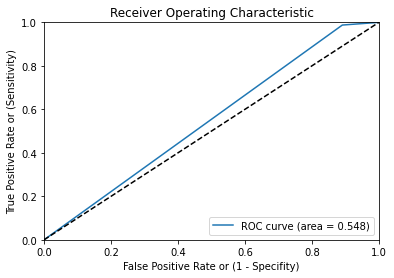

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

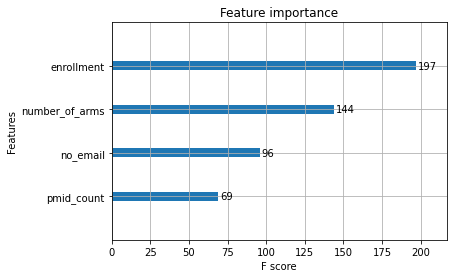

In [0]:
from xgboost import plot_importance
# plot feature importance
plot_importance(model)
plt.show()

# Clinical trials classifier using pubmed features (very limited at the moment as feature eng just beginning) 

## Load data and assign labels

In [0]:
# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'harvard-599-trendsetters'

df = pd.io.gbq.read_gbq(f'''
   SELECT
    gene_disease_relationship,
    CASE 
      WHEN phase IN ('Phase 1', 'Early Phase 1') AND overall_status IN ('Completed', 'Suspended', 'Withdrawn', 'Terminated') THEN 0
      WHEN phase IN ('Phase 2', 'Phase 3', 'Phase 4') THEN 1 
      ELSE -1
    END AS classifier_label,
    a.pmid,
    ARRAY_LENGTH(b.authors) AS num_authors,
    ARRAY_LENGTH(b.chemicals) AS num_chemicals,
    CHAR_LENGTH(b.article_title) as article_title_length,
    CHAR_LENGTH(b.abstract) as abstract_length,
    b.language,
    b.title as title,
    b.pub_model as pub_model,
    COUNT(DISTINCT b.pub_model) OVER (PARTITION BY gene_disease_relationship) AS total_pub_models_relationship_is_in,
    COUNT(DISTINCT b.language) OVER (PARTITION BY gene_disease_relationship) AS total_distinct_languages_relationship_in,
    COUNT(DISTINCT b.title) OVER (PARTITION BY gene_disease_relationship) AS total_distinct_journals_relationship_is_in,
    COUNT(DISTINCT a.pmid) OVER (PARTITION BY gene_disease_relationship) AS total_pubmed_articles_on_relationship
    FROM `harvard-599-trendsetters.aact.complete_data_ready_for_feature_eng` AS a
    LEFT JOIN `harvard-599-trendsetters.pubmed.baseline_02032020` AS b
      ON a.pmid=b.pmid

''', project_id=project_id)



In [0]:
df.head()

,gene_disease_relationship,classifier_label,pmid,num_authors,num_chemicals,article_title_length,abstract_length,language,title,pub_model,total_pub_models_relationship_is_in,total_distinct_languages_relationship_in,total_distinct_journals_relationship_is_in,total_pubmed_articles_on_relationship
0,obese-visceral obesity,-1,21676388,2.0,4.0,50.0,428.0,eng,Environmental research,Print-Electronic,2,1,3,3
1,obese-visceral obesity,-1,21676388,2.0,4.0,50.0,428.0,eng,Environmental research,Print-Electronic,2,1,3,3
2,obese-visceral obesity,-1,31528831,5.0,0.0,78.0,1399.0,eng,Journal of the Endocrine Society,Electronic-eCollection,2,1,3,3
3,obese-visceral obesity,-1,31528831,5.0,0.0,78.0,1399.0,eng,Journal of the Endocrine Society,Electronic-eCollection,2,1,3,3
4,obese-visceral obesity,-1,26752053,4.0,5.0,96.0,2019.0,eng,PloS one,Electronic-eCollection,2,1,3,3


In [0]:
df.classifier_label.value_counts()

-1    134675
 1     32012
 0      4661
Name: classifier_label, dtype: int64

In [0]:
df = df[df.classifier_label!= -1]
df.classifier_label.value_counts()

1    32012
0     4661
Name: classifier_label, dtype: int64

In [0]:
df.shape

(36673, 14)

## Feature engineering

In [0]:
dummies_language = pd.get_dummies(df.language)
dummies_language.head()

,bul,chi,cze,dan,dut,eng,fre,ger,heb,hun,ita,jpn,lit,nor,pol,por,rum,rus,spa,swe,ukr
7,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
dummies_pub_model = pd.get_dummies(df.pub_model)
dummies_pub_model.head()

,Electronic,Electronic-Print,Electronic-eCollection,Print,Print-Electronic
7,0,0,0,0,1
8,0,0,0,0,1
15,0,0,0,1,0
16,0,0,0,1,0
23,0,0,0,1,0


In [0]:
top_n_journal = list(df.title.value_counts().head(5).index)
top_n_journal

['Chemico-biological interactions',
 'The Journal of rheumatology',
 'Arthritis and rheumatism',
 'Environmental health perspectives',
 'Toxicology and applied pharmacology']

In [0]:
df['title'][~df.title.isin(top_n_journal)] = 'Other'

In [0]:
dummies_journal = pd.get_dummies(df.title)
dummies_journal.head()

,Arthritis and rheumatism,Chemico-biological interactions,Environmental health perspectives,Other,The Journal of rheumatology,Toxicology and applied pharmacology
7,0,0,0,1,0,0
8,0,0,0,1,0,0
15,0,0,0,1,0,0
16,0,0,0,1,0,0
23,1,0,0,0,0,0


In [0]:
df = df.join(dummies_language)
df = df.join(dummies_pub_model)
df = df.join(dummies_journal)


In [0]:
df.head()

,gene_disease_relationship,classifier_label,pmid,num_authors,num_chemicals,article_title_length,abstract_length,language,title,pub_model,total_pub_models_relationship_is_in,total_distinct_languages_relationship_in,total_distinct_journals_relationship_is_in,total_pubmed_articles_on_relationship,bul,chi,cze,dan,dut,eng,fre,ger,heb,hun,ita,jpn,lit,nor,pol,por,rum,rus,spa,swe,ukr,Electronic,Electronic-Print,Electronic-eCollection,Print,Print-Electronic,Arthritis and rheumatism,Chemico-biological interactions,Environmental health perspectives,Other,The Journal of rheumatology,Toxicology and applied pharmacology
7,fib-ra,1,17878395,2.0,2.0,54.0,131.0,eng,Other,Print-Electronic,3,7,90,192,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
8,fib-ra,1,17878395,2.0,2.0,54.0,131.0,eng,Other,Print-Electronic,3,7,90,192,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
15,fib-ra,1,3136089,8.0,3.0,160.0,1729.0,eng,Other,Print,3,7,90,192,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
16,fib-ra,1,3136089,8.0,3.0,160.0,1729.0,eng,Other,Print,3,7,90,192,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
23,fib-ra,1,2920047,3.0,2.0,155.0,1377.0,eng,Arthritis and rheumatism,Print,3,7,90,192,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


In [0]:
df.gene_disease_relationship.value_counts().head(10)

obese-ra                          8568
obese-type 2 diabetes             4862
obese-steatohepatitis             1872
obese-type 2 diabetes mellitus    1859
obese-liver disease               1551
obese-ad                          1550
obese-cancer                      1342
obese-kidney disease               994
obese-breast cancer                970
obese-vascular disease             918
Name: gene_disease_relationship, dtype: int64

## Train classifier

In [0]:
Y = df.pop('classifier_label')


In [0]:
gene_disease_relationship = df.pop('gene_disease_relationship')
df.columns

Index(['pmid', 'num_authors', 'num_chemicals', 'article_title_length',
       'abstract_length', 'language', 'title', 'pub_model',
       'total_pub_models_relationship_is_in',
       'total_distinct_languages_relationship_in',
       'total_distinct_journals_relationship_is_in',
       'total_pubmed_articles_on_relationship', 'bul', 'chi', 'cze', 'dan',
       'dut', 'eng', 'fre', 'ger', 'heb', 'hun', 'ita', 'jpn', 'lit', 'nor',
       'pol', 'por', 'rum', 'rus', 'spa', 'swe', 'ukr', 'Electronic',
       'Electronic-Print', 'Electronic-eCollection', 'Print',
       'Print-Electronic', 'Arthritis and rheumatism',
       'Chemico-biological interactions', 'Environmental health perspectives',
       'Other', 'The Journal of rheumatology',
       'Toxicology and applied pharmacology'],
      dtype='object')

In [0]:
X = df[[ 'total_pubmed_articles_on_relationship', 'total_distinct_journals_relationship_is_in',
       'bul', 'chi', 'cze', 'dan', 'dut', 'eng', 'fre', 'ger',
       'heb', 'hun', 'ita', 'jpn', 'nor', 'pol', 'por', 'rum', 'rus',
       'spa', 'swe', 'ukr', 'Electronic', 'Electronic-Print',
       'Electronic-eCollection', 'Print', 'Print-Electronic',
        'num_chemicals',
        'abstract_length',
        'article_title_length',
          'Arthritis and rheumatism',
       'Chemico-biological interactions', 'Environmental health perspectives',
       'Other', 'The Journal of rheumatology',
       'Toxicology and applied pharmacology'
        ]]

In [0]:
Y.value_counts()

1    32012
0     4661
Name: classifier_label, dtype: int64

In [0]:
X.head()

,total_pubmed_articles_on_relationship,total_distinct_journals_relationship_is_in,bul,chi,cze,dan,dut,eng,fre,ger,heb,hun,ita,jpn,nor,pol,por,rum,rus,spa,swe,ukr,Electronic,Electronic-Print,Electronic-eCollection,Print,Print-Electronic,num_chemicals,abstract_length,article_title_length,Arthritis and rheumatism,Chemico-biological interactions,Environmental health perspectives,Other,The Journal of rheumatology,Toxicology and applied pharmacology
7,192,90,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.0,131.0,54.0,0,0,0,1,0,0
8,192,90,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.0,131.0,54.0,0,0,0,1,0,0
15,192,90,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.0,1729.0,160.0,0,0,0,1,0,0
16,192,90,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.0,1729.0,160.0,0,0,0,1,0,0
23,192,90,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.0,1377.0,155.0,1,0,0,0,0,0


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [0]:
y_train

152012    1
127118    0
130354    1
61630     0
47543     1
         ..
21313     1
93347     1
6710      1
72257     1
55740     1
Name: classifier_label, Length: 27504, dtype: int64

In [0]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = model.predict(X_test)

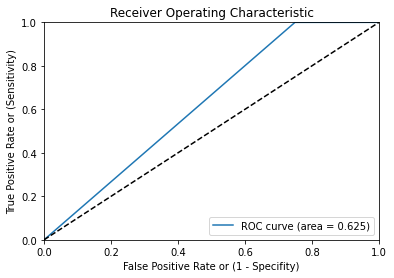

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

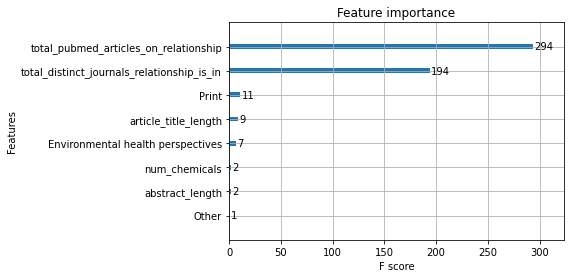

<Figure size 720x1080 with 0 Axes>

In [0]:
from xgboost import plot_importance
# plot feature importance
plot_importance(model)
plt.figure(figsize=(10, 15))
plt.show()

# Clinical trials classifier using pubmed features BUT ONLY FOR PMIDS EXPLICITLY SPECIFIED IN REFERENCE OF TRIAL

## Load data and assign labels

In [0]:
# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'harvard-599-trendsetters'

df = pd.io.gbq.read_gbq(f'''
   SELECT
      gene_disease_relationship,
      classifier_label,
      COUNT(DISTINCT pmids) as num_pmids,
      COUNT(DISTINCT title) as num_publications,
      AVG(num_authors) AS avg_authors
  FROM (
    SELECT
      a.nct_id,
      a.pmid,
      a.overall_status,
      a.phase,
      CASE
        WHEN SUBSTR(a.phase, 7, 1) IN ("2", "3", "4") THEN 1
        WHEN SUBSTR(a.phase, 7, 1) = "1" AND overall_status IN ('Completed', 'Suspended', 'Withdrawn', 'Terminated') THEN 0
        ELSE -1
      END AS classifier_label,
      GeneSymbol,
      GeneID,
      DiseaseID,
      CONCAT(GeneSymbol, '-', DiseaseID) AS gene_disease_relationship,
      disease_genes.pmids,
      pubmed_meta.title,
      pubmed_meta.article_title, 
      pubmed_meta.language,
      ARRAY_LENGTH(pubmed_meta.authors) AS num_authors
    FROM `harvard-599-trendsetters.aact.only_trials_with_pmid_refs` as a
    INNER JOIN  `harvard-599-trendsetters.ctd.gene_disease_pmids_unnested` AS disease_genes
      ON a.pmid=disease_genes.pmids
    INNER JOIN `harvard-599-trendsetters.pubmed.baseline_02032020` AS pubmed_meta
      on a.pmid=pubmed_meta.pmid
    GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
    ORDER BY a.nct_id desc
    )
    GROUP BY 1, 2
    HAVING classifier_label != -1
''', project_id=project_id)



In [0]:
df.head()

,gene_disease_relationship,classifier_label,num_pmids,num_publications,avg_authors
0,AK3-MESH:D006333,1,6,4,7.125000
1,CASR-MESH:D054198,1,3,2,8.333333
2,CYP19A1-MESH:D001943,1,18,13,11.911765
3,LEP-MESH:D006973,1,20,17,8.086957
4,FGB-MESH:D001172,1,3,3,11.833333


In [0]:
df.classifier_label.value_counts()

1    65
0    20
Name: classifier_label, dtype: int64

In [0]:
df.shape

(85, 5)

## Feature engineering

## Train classifier

In [0]:
Y = df.pop('classifier_label')


In [0]:
gene_disease_relationship = df.pop('gene_disease_relationship')
df.columns

Index(['num_pmids', 'num_publications', 'avg_authors'], dtype='object')

In [0]:
X = df

In [0]:
Y.value_counts()

1    65
0    20
Name: classifier_label, dtype: int64

In [0]:
X.head()

,num_pmids,num_publications,avg_authors
0,6,4,7.125000
1,3,2,8.333333
2,18,13,11.911765
3,20,17,8.086957
4,3,3,11.833333


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [0]:
y_train

17    1
18    1
41    0
22    1
56    1
     ..
35    1
33    1
77    1
24    1
11    1
Name: classifier_label, Length: 63, dtype: int64

In [0]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = model.predict(X_test)

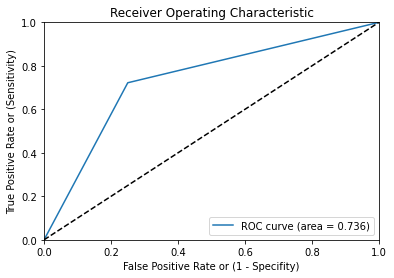

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

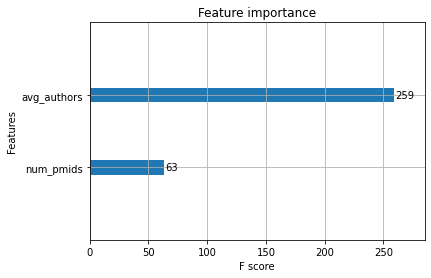

<Figure size 720x1080 with 0 Axes>

In [0]:
from xgboost import plot_importance
# plot feature importance
plot_importance(model)
plt.figure(figsize=(10, 15))
plt.show()